In [1]:
import torch
import torchvision
import time
import torch.nn.functional as F
import tensorflow as tf

from torchvision import transforms, datasets
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder
from torchinfo import summary
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [3]:
has_gpu = torch.cuda.is_available()
#for mac
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

random_seed = 1
batch_size = 128
num_epochs = 10
num_classes = 10

GPU is NOT AVAILABLE
MPS (Apple Metal) is NOT AVAILABLE
Target device is cpu


In [5]:
train_data_transform_example = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomCrop((224, 224)),
    torchvision.transforms.ToTensor(),
    ])

train_dataset = tf.data.TFRecordDataset('newDatasets.train.tfrecord')
#train_dataset = train_dataset.Resnet50(train=True, transform=train_data_transform_example, download=True)
#train_dataset = train_dataset('./train_dataset/', train=True, transform=train_data_transform_example, download=True)
train_dir = 'newDatasets/train'
train_dataset = torchvision.datasets.ImageFolder(
    root=train_dir,
    transform=train_data_transform_example,
)


train_loader_example = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=3,
    shuffle=False
)

batch_mean_list = []
batch_std_list = []

for ii, image in enumerate(train_loader_example, 0):
    np_image = image[0].numpy()
    batch_mean = np.mean(np_image, axis=(0, 2, 3))
    batch_std = np.std(np_image, axis=(0, 2, 3))
    
    batch_mean_list.append(batch_mean)
    batch_std_list.append(batch_std)
train_mean = np.mean(batch_mean_list, axis=0)
train_std = np.mean(batch_std_list, axis=0)

print('Mean of all train images:', train_mean)
print('Std Dev of all train images:', train_std)

Mean of all train images: [0.48617944 0.4808387  0.41556928]
Std Dev of all train images: [0.30297762 0.2784286  0.30422115]


In [6]:
train_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomCrop((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

test_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),        
    torchvision.transforms.CenterCrop((224, 224)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
    ])

In [7]:
train_dataset = ImageFolder(root="newDatasets/train", transform=train_data_transform)
test_dataset = ImageFolder(root="newDatasets/test", transform=test_data_transform)
valid_dataset = ImageFolder(root="newDatasets/valid", transform=test_data_transform)
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset ))
train_dataset, valid_dataset = random_split(train_dataset, lengths=[736,150])

886
254
124


In [8]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=3,
    shuffle=False
)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)

Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([128, 3, 224, 224])


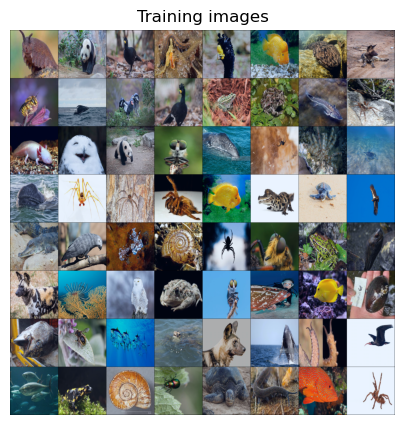

Labels = 
[[9 6 2 9 2 4 0 6]
 [5 6 2 2 0 0 4 1]
 [0 2 6 5 6 1 3 8]
 [6 1 1 1 4 8 8 2]
 [8 2 3 7 1 5 0 8]
 [6 3 2 0 5 4 4 7]
 [4 5 4 8 6 6 9 2]
 [4 0 7 5 8 9 4 1]]


In [7]:
import torchvision.utils as vutils

%matplotlib inline
import matplotlib.pyplot as plt

im_batch = next(iter(train_loader))
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch[0].shape)
plt.figure(figsize=(5, 5))
plt.title("Training images")
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(im_batch[0][:64], nrow=8, padding=1, normalize=True), (1, 2, 0)
    )
)
plt.show()
print("Labels = " )
print(im_batch[1][:64].data.numpy().reshape(8,-1))

In [8]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Print the model
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 224),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(224, num_classes),
)

In [10]:
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        true_pred = 0
        tot_samples = 0
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, label_pred = torch.max(logits, axis=1)
            true_pred += (label_pred==labels).sum()
            tot_samples += labels.shape[0]
        acc = (true_pred/float(tot_samples))*100
    return acc

In [12]:
def calculate_train_loss(model, data_loader, device):
    total_loss = 0.0
    num_samples = 0
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)
            num_samples += labels.size(0)
    avg_loss = total_loss / num_samples
    return avg_loss

In [13]:
def validate_loss(model, data_loader, device):
        total_loss = 0.0
        num_samples = 0
        criterion = torch.nn.CrossEntropyLoss()
        with torch.no_grad():
            for imgs, labels in data_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                logits = model(imgs)
                loss = criterion(logits, labels)
                total_loss += loss.item() * labels.size(0)
                num_samples += labels.size(0)
        avg_loss = total_loss / num_samples
        return avg_loss

In [14]:
torch.manual_seed(random_seed)
base_learning_rate = 1e-5 # for fine-tuning - low learning rates
fc_learning_rate = 1e-2

# Set different learning rates for different param_groups
optimizer = torch.optim.Adam([
    {'params': [param for name, param in model.named_parameters() if 'fc' not in name]}, 
    {'params': model.fc.parameters(), 'lr': fc_learning_rate, 'weight_decay':0.5}
    ], lr=base_learning_rate)
# Set up a Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [15]:
start = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        ## Forward Propagation - extract features and classify
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)

        #zero out the gradients
        optimizer.zero_grad()
        #estimate new gradients
        loss.backward()
        #update parameters
        optimizer.step()
        
        # Print Performance every 100 mini-batches
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:02d}/{num_epochs:02d} | "
                f"Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | "
                f"Loss: {loss:.5f}"
            )
    
    # Tracking the Learning Rate Scheduler
    prev_lr_base = optimizer.param_groups[0]["lr"]
    prev_lr_fc = optimizer.param_groups[1]["lr"]
    scheduler.step()
    current_lr_base = optimizer.param_groups[0]["lr"]
    current_lr_fc = optimizer.param_groups[1]["lr"]
    print(f"Epoch: {epoch+1:03d} Base Learning Rate {prev_lr_base:.8f} -> {current_lr_base:.8f}")
    print(f"Epoch: {epoch+1:03d} FC Learning Rate {prev_lr_fc:.8f} -> {current_lr_fc:.8f}")
    
    # Evaluate Performance after each epoch
    model = model.eval()
    tr_acc = accuracy(model, train_loader, device)
    valid_acc = accuracy(model, valid_loader, device)
    valid_loss = validate_loss(model, valid_loader, device)
    tr_loss = calculate_train_loss(model, train_loader,device)
    
    train_acc_list = []
    train_loss_list = []
    valid_acc_list = []
    valid_loss_list = []
        
    train_acc_list.append(tr_acc)
    train_loss_list.append(tr_loss)
    valid_acc_list.append(valid_acc)
    valid_loss_list.append(valid_loss) 
    
    print(f"Train Accuracy: {tr_acc:0.3f}")
    print(f"Validation Accuracy: {valid_acc:0.3f}")
    print(f"Time elapsed so far: {(time.time() - start) / 60:.2f} min")

print(f"Total Train Time: {(time.time() - start) / 60:.2f} min")

Epoch: 001 Base Learning Rate 0.00001000 -> 0.00001000
Epoch: 001 FC Learning Rate 0.01000000 -> 0.01000000
Train Accuracy: 28.750
Validation Accuracy: 28.000
Time elapsed so far: 21.87 min
Epoch: 002 Base Learning Rate 0.00001000 -> 0.00001000
Epoch: 002 FC Learning Rate 0.01000000 -> 0.01000000
Train Accuracy: 59.688
Validation Accuracy: 54.000
Time elapsed so far: 43.26 min
Epoch: 003 Base Learning Rate 0.00001000 -> 0.00000500
Epoch: 003 FC Learning Rate 0.01000000 -> 0.00500000
Train Accuracy: 74.375
Validation Accuracy: 76.667
Time elapsed so far: 65.41 min
Epoch: 004 Base Learning Rate 0.00000500 -> 0.00000500
Epoch: 004 FC Learning Rate 0.00500000 -> 0.00500000
Train Accuracy: 93.125
Validation Accuracy: 91.333
Time elapsed so far: 86.93 min
Epoch: 005 Base Learning Rate 0.00000500 -> 0.00000500
Epoch: 005 FC Learning Rate 0.00500000 -> 0.00500000
Train Accuracy: 83.750
Validation Accuracy: 81.333
Time elapsed so far: 108.51 min
Epoch: 006 Base Learning Rate 0.00000500 -> 0.000

In [16]:
ts_acc = accuracy(model, test_loader, device)
print(f"Test Accuracy: {ts_acc:0.3f}")

Test Accuracy: 85.827


In [17]:
tr_acc = accuracy(model, train_loader, device)
print(f"Train Accuracy: {tr_acc:0.3f}")

Train Accuracy: 90.000


In [18]:
vl_acc = accuracy(model, valid_loader, device)
print(f"Valid Accuracy: {vl_acc:0.3f}")

Valid Accuracy: 90.667


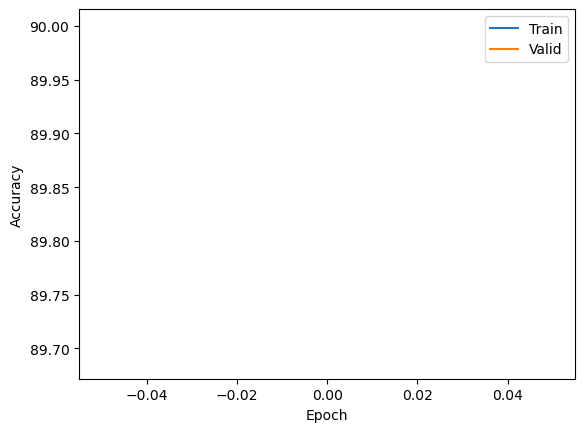

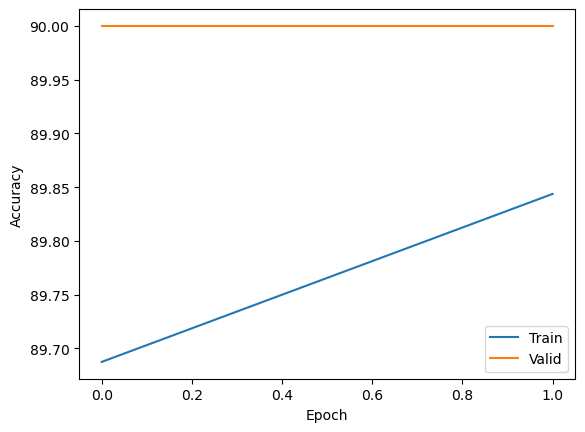

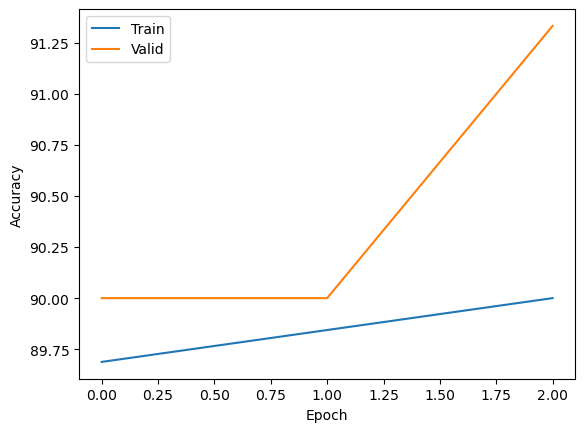

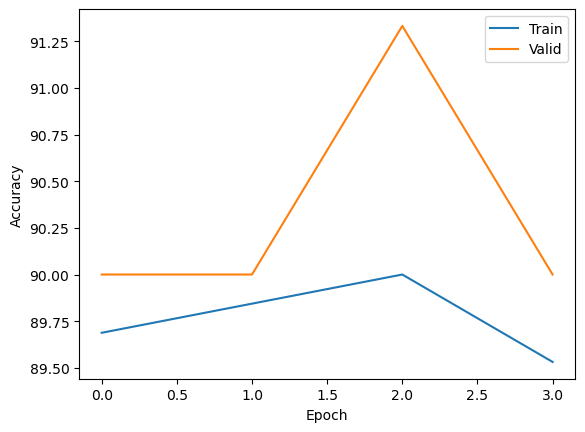

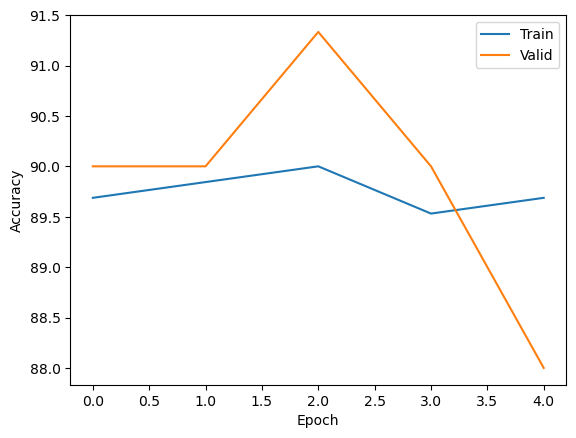

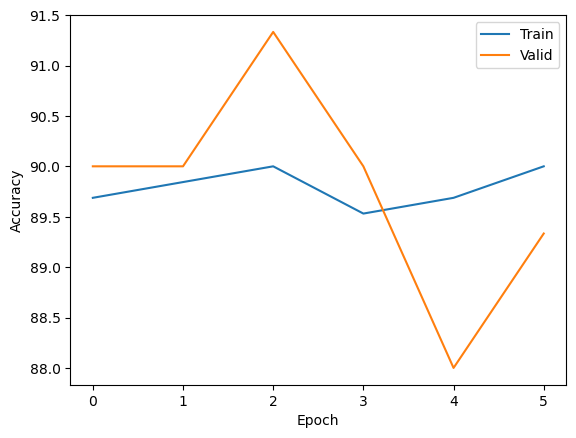

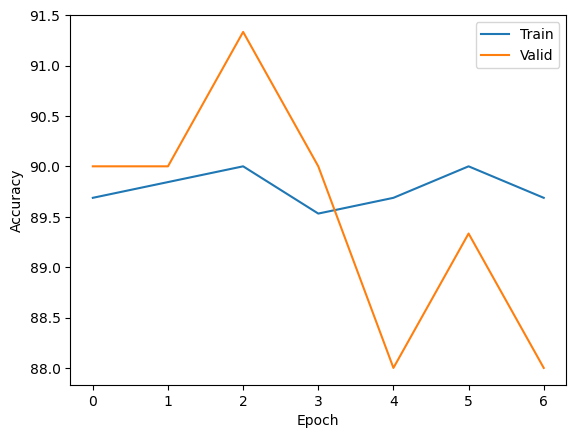

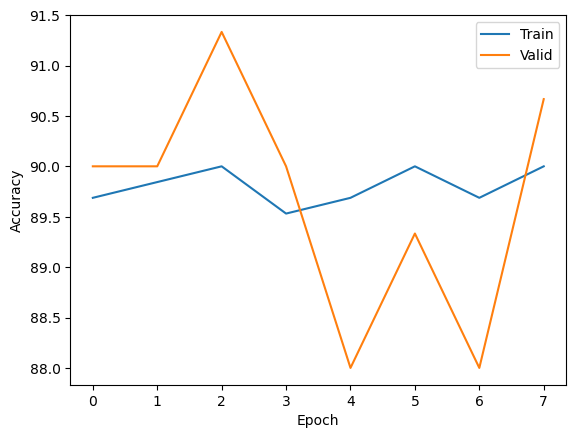

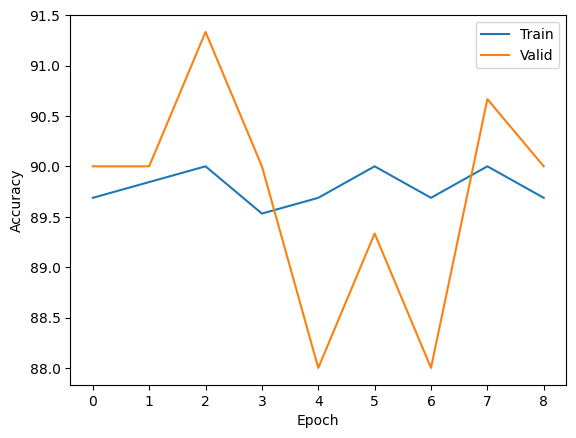

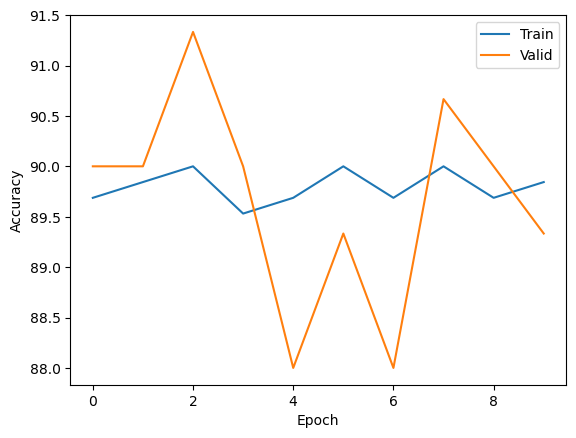

In [19]:
train_acc_list = []
valid_acc_list = []

for epoch in range(num_epochs):
    train_acc = accuracy(model, train_loader,device)
    valid_acc = accuracy(model, valid_loader, device)
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)
    
    plt.plot(np.arange(epoch+1), train_acc_list, label='Train')
    plt.plot(np.arange(epoch+1), valid_acc_list, label='Valid')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
true_labels = []
pred_labels = []
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(predicted.cpu().numpy())
cm = confusion_matrix(true_labels, pred_labels)
print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

NameError: name 'valid_loader' is not defined